In [2]:
import os

from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy.coordinates import get_moon

from astropy import units as u
from astropy.time import Time
from astropy.time import TimeDelta
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator

import easyaccess as ea
import numpy as np
#import seaborn as sns
import pandas as pd

In [3]:
#Now select from the Database
connection =ea.connect()
cursor     =connection.cursor()

query = "select expnum, radeg, decdeg, field, nite, band, mjd_obs, exptime " \
        "from EXPOSURE where FIELD like 'SN-%' and NITE > 20130606 and NITE < 20160606 and exptime > 30"

exp=connection.query_to_pandas(query) #one line!
exp = exp.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

Connecting to DB ** desoper ** ...


### Determine Number of exposures (good and bad); on-sky time; number of epochs taken

In [4]:
#Now to download the data quality from the COADDS (SN_STATUS)

qual = pd.read_csv('sn_status.txt', sep=" ", header=None)
qual.columns = ["a", "NITE", "FIELD", "BAND", "ATT", "EXPNUM", "STATUS", "PSF",  
                "AIR", "FAKE", "zPSF", "SNR20", "EFF50", "ACCEPT"]
#Strip whitespace
#Turn NITE into STRING
qual['NITE'] = qual['NITE'].apply(str)
qual = qual.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

#Update so we're only looking at first three years
qual = qual.query("NITE > '20130606' and NITE < '20160606'")

#Get rid of fact that the table seems to double-count some filter-fields; these are in SN_STATUS with no BAND entry
qual = qual[~qual['BAND'].isnull()]

In [5]:
#Store in array 't' those exposures which passed Data Quality cuts.
print 'Total filter-epochs: ', len(qual)

t = qual.query("ACCEPT == 'True'")
print 'Total good filter-epochs: ', len(t)
print '---'

print 'Total DEEP filter-epochs: ', len(qual.query("FIELD == 'SN-C3' or FIELD == 'SN-X3'"))
print 'Total good DEEP filter-epochs: ', len(t.query("FIELD == 'SN-C3' or FIELD == 'SN-X3'"))

Total filter-epochs:  3179
Total good filter-epochs:  2663
---
Total DEEP filter-epochs:  569
Total good DEEP filter-epochs:  500


In [6]:
#Set a filter-field epochs table.  This should be the same length as qual.
FFE_DQ = qual.groupby(['NITE','FIELD','BAND']).size().reset_index().rename(columns={0:'count'})
print len(FFE_DQ)
FFE_DQ.info()

3179
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3179 entries, 0 to 3178
Data columns (total 4 columns):
NITE     3179 non-null object
FIELD    3179 non-null object
BAND     3179 non-null object
count    3179 non-null int64
dtypes: int64(1), object(3)
memory usage: 99.4+ KB


In [7]:
#Percent of Shallow Field exposures that fail: 447/2610 = 17%
#Percent of Deep Field exposures that fail:  69/569 = 12%

In [8]:
#Now select from the Database
connection =ea.connect()
cursor     =connection.cursor()

query = "select expnum, radeg, decdeg, field, nite, band, mjd_obs, exptime " \
        "from EXPOSURE where FIELD like 'SN-%' and NITE > 20130606 and NITE < 20160606 and exptime > 30"

exp=connection.query_to_pandas(query) #one line!
exp = exp.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

Connecting to DB ** desoper ** ...


In [9]:
#Determine number of exposures and total exposure time from DB
print 'From EXPOSURE TABLE'
print 'Total Number of Exposures and Hours:  ', len(exp), np.sum(exp['EXPTIME'])/3600.
print '----'

for i in range(3):
    date = "201{0}0606"
    test = exp.query("NITE > '{0}' and NITE < '{1}'".format(date.format(3+i), date.format(4+i)))

    print 'Number of Exposures and Hours in Y{0}: '.format(i),len(test),np.sum(test['EXPTIME'])/3600.
    
#Print number of filter-field epochs
FFE_DB = exp.groupby(['NITE','FIELD','BAND']).size().reset_index().rename(columns={0:'count'})
print len(FFE_DB)

From EXPOSURE TABLE
Total Number of Exposures and Hours:   6877 487.6944443
----
Number of Exposures and Hours in Y0:  2267 160.670833333
Number of Exposures and Hours in Y1:  2366 169.186111111
Number of Exposures and Hours in Y2:  2244 157.837499856
3423


In [10]:
#Q1:  Why so many more filter-field epochs that aren't in SN_STATUS (244, or 81 per season, 
#     or 2 nites per filter-field-season)

#Merge the per-exposure DQ with the EXPOSURE table.
FFE_DIFF = pd.merge(FFE_DB, FFE_DQ, how = 'left', on = ['NITE','BAND','FIELD'], suffixes=('_DB','_DQ'))
missing = FFE_DIFF[FFE_DIFF['count_DQ'].isnull()]
print len(missing)
print missing

244
          NITE  FIELD BAND  count_DB  count_DQ
0     20130815  SN-E1    g         3       NaN
1     20130815  SN-E1    i         1       NaN
2     20130815  SN-E1    r         3       NaN
3     20130815  SN-E1    z         2       NaN
4     20130815  SN-E2    g         1       NaN
5     20130815  SN-E2    i         1       NaN
6     20130815  SN-E2    r         1       NaN
7     20130815  SN-E2    z         1       NaN
8     20130829  SN-C1    g         1       NaN
9     20130829  SN-C1    i         1       NaN
10    20130829  SN-C1    r         1       NaN
11    20130829  SN-C1    z         2       NaN
12    20130829  SN-E1    g         1       NaN
13    20130829  SN-E1    i         1       NaN
14    20130829  SN-E1    r         1       NaN
15    20130829  SN-E1    z         2       NaN
16    20130829  SN-E2    g         1       NaN
17    20130829  SN-E2    i         1       NaN
18    20130829  SN-E2    r         1       NaN
19    20130829  SN-E2    z         2       NaN
20    201

On March 1, 2018, I checked the above listed of 244 exposures against a file provided by Eric Neilsen, obtained by querying SISPI.  Most of the exposures above have 'no assessment', which technically means they passed as far as obtaining new data is concerned.  There are **only 4 sequences*  that were rejected:

20130831, C3g
20131207, C3r
20150918, X1
20150924, C1

The following sequences were aborted and retaken, thus also should be considered rejected:

20130831, S1
20130905, C3g
20131117, X3z
20150924, C1
20151002, S1
20151020, X3z


In [11]:
reject = {'NITE':  [20130831, 20131207, 20150918, 20150918, 20150918, 20150918, 
                    20150924, 20150924, 20150924, 20150924, 20130831, 20130831, 20130831, 20130831,
                    20130905, 20131117, 20150924, 20150924, 20150924, 20150924, 
                    20151002, 20151002, 20151002, 20151002, 20151020], 
          'FIELD': ['SN-C3', 'SN-C3', 'SN-X1', 'SN-X1', 'SN-X1', 'SN-X1', 'SN-C1', 'SN-C1',
                    'SN-C1', 'SN-C1', 'SN-S1', 'SN-S1', 'SN-S1', 'SN-S1', 'SN-C3', 'SN-X3',
                    'SN-C1', 'SN-C1', 'SN-C1', 'SN-C1', 'SN-S1', 'SN-S1', 'SN-S1', 'SN-S1',
                    'SN-X3'],
          'BAND':  ['g', 'r', 'g', 'r', 'i', 'z', 'g', 'r', 'i', 'z', 'g', 'r', 'i', 'z', 
                    'g', 'z', 'g', 'r', 'i', 'z', 'g', 'r', 'i', 'z', 'z'], 
          'REJECT': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

reject = pd.DataFrame(reject)
reject['NITE'] = reject['NITE'].apply(str)


In [12]:
print len(reject)

ggg = pd.merge(missing, reject, how='left', on=['NITE', 'FIELD', 'BAND'])

25


In [13]:
a = ggg[ggg['REJECT'].isnull()]
print len(a)
print len(missing)

228
244


In [14]:
#Look at all the epochs for which we're missing DQ assessments
check = False

if check == True:
    for index, row in missing.iterrows():
    
        NITE  = row['NITE']
        FIELD = row['FIELD']
        BAND  = row['BAND'] 

        query = "select count(*) as CNT from SNOBS where NITE = '{0}' and FIELD = '{1}' and BAND = '{2}'"
        query = query.format(NITE,FIELD[3:],BAND)
        
        temp=connection.query_to_pandas(query) #one line!
        print NITE, FIELD, BAND, temp.loc[0,'CNT']

In [15]:
#Q2:  Determine useful exposure time by summing over the merged quantity of above.

new_test = pd.merge(exp, qual, how = 'left', on = ['NITE','BAND','FIELD'], suffixes=('_DB','_DQ'))
print len(new_test)

6877


In [23]:
t = new_test.query("ACCEPT == 'True'")

print 'Total Number of ACCEPTED Exposures and Hours:  ', len(t), np.sum(t['EXPTIME'])/3600.
print '----'

for i in range(3):
    date = "201{0}0606"
    test = t.query("NITE > '{0}' and NITE < '{1}'".format(date.format(3+i), date.format(4+i)))

    print 'Number of Exposures and Hours in Y{0}: '.format(i),len(test),np.sum(test['EXPTIME'])/3600.
    
#Print number of filter-field epochs
t2 = t.groupby(['NITE','FIELD','BAND']).size().reset_index().rename(columns={0:'count'})
print len(t2)

Total Number of ACCEPTED Exposures and Hours:   5485 393.073611052
----
Number of Exposures and Hours in Y0:  1628 117.340277778
Number of Exposures and Hours in Y1:  1915 137.529166667
Number of Exposures and Hours in Y2:  1942 138.204166607
2663


In [30]:
a1 = new_test[new_test['ACCEPT'] == 'True']
#a2 = new_test[(new_test['ACCEPT'] != 'True') & (~new_test['ACCEPT'].isnull())]
a2 = new_test[(new_test['ACCEPT'] == 'True') | (new_test['ACCEPT'].isnull())]
a3 = new_test[new_test['ACCEPT'].isnull()]

print len(a1),len(a2),len(a3)

print np.sum(a1['EXPTIME'])/3600.,np.sum(a2['EXPTIME'])/3600.,np.sum(a3['EXPTIME'])/3600.

#Note from 29 October 2018:  We count as passed (good quality) everything without an assessment, since practically
#that's how it was considered.  Thus I want to use 'ACCEPT' == True AND ACCEPT isnull

5485 5974 489
393.073611052 427.927777718 34.8541666667


---

### Now we determine the length of the observing season

Length is from first exposure to last
Cadence (later) is from first GOOD exposure to last GOOD exposure

In [18]:
season_duration1 = {}
season_duration2 = {}

#new_test is merger of exposure table (left) and 
t1 = new_test.query("ACCEPT == 'True'")
t2 = new_test

print type(t)

for i in range(3):
    date = "201{0}0606"
    
    #First, all good data
    temp = t1.query("NITE > '{0}' and NITE < '{1}'".format(date.format(3+i),date.format(4+i)))
    df1 = temp.groupby(['FIELD','BAND'])['MJD_OBS'].max()
    df2 = temp.groupby(['FIELD','BAND'])['MJD_OBS'].min()
    
    t   = df1 - df2
    season_duration1[i] = t

    #Then all data
    temp = t2.query("NITE > '{0}' and NITE < '{1}'".format(date.format(3+i),date.format(4+i)))
    df1 = temp.groupby(['FIELD','BAND'])['MJD_OBS'].max()
    df2 = temp.groupby(['FIELD','BAND'])['MJD_OBS'].min()
    
    t   = df1 - df2
    season_duration2[i] = t

    
season_good = pd.concat(season_duration1, axis=1)   
season_good = season_good.reset_index()

season_all = pd.concat(season_duration2, axis=1)   
season_all = season_all.reset_index()

<class 'pandas.core.frame.DataFrame'>


In [19]:
print season_good
print season_all

    FIELD BAND           0           1           2
0   SN-C1    g  140.763127  178.639434  174.816386
1   SN-C1    i  140.763136  178.639408  174.816394
2   SN-C1    r  140.763116  178.639408  174.816391
3   SN-C1    z  140.765768  178.642042  174.819040
4   SN-C2    g  139.814621  176.695847  173.854416
5   SN-C2    i  139.814632  176.695832  173.854416
6   SN-C2    r  146.830235  176.695855  173.854417
7   SN-C2    z  146.832873  176.698459  155.792362
8   SN-C3    g  134.870239  177.748703  175.712872
9   SN-C3    i  137.833056  175.744394  174.798302
10  SN-C3    r  135.819889  180.704764  175.837880
11  SN-C3    z  136.902504  181.787840  172.830737
12  SN-E1    g  138.999501  165.826629  171.850733
13  SN-E1    i  138.999464  165.826608  171.850758
14  SN-E1    r  138.999462  165.826621  171.850754
15  SN-E1    z  139.002094  165.829240  171.853408
16  SN-E2    g  143.953529  161.830305  167.867355
17  SN-E2    i  143.953557  161.830299  167.867369
18  SN-E2    r  131.980586  161

In [20]:
for i in range(3):
    print 'Length of season {0} (good/all): '.format(i),np.mean(season_good[i]),np.mean(season_all[i]) 

    
print 'Length of season by field (all):'
for i in ['SN-C','SN-E','SN-S','SN-X']:
    dfg = season_all[season_all['FIELD'].str.contains(i)]
    print i,np.mean(np.mean(dfg))
    
    
print 'Length of season by Deep/shallow (all):'
test1 = season_all.query("FIELD == 'SN-X3' or FIELD == 'SN-C3'")
test2 = season_all.query("FIELD != 'SN-X3' and FIELD != 'SN-C3'")
print 'Deep: ',np.mean(np.mean(test1))
print 'Shallow: ',np.mean(np.mean(test2))


Length of season 0 (good/all):  139.312776914 163.334549612
Length of season 1 (good/all):  163.456085718 167.779808344
Length of season 2 (good/all):  166.246834751 169.7818546
Length of season by field (all):
SN-C 171.114510907
SN-E 171.175376693
SN-S 160.269803118
SN-X 164.473383169
Length of season by Deep/shallow (all):
Deep:  164.473128438
Shallow:  167.588473122


In [39]:
#Get typical Nexp for GOOD data, and for ALL data
good = True

if good == True:
#    t = new_test.query("ACCEPT == 'True'")
    t = new_test.query("(ACCEPT == 'True') or (ACCEPT != ACCEPT)")
    print 'GOOD'
else:
    t = new_test
    print 'ALL'


cadence_test = {}

for i in range(3):
    date = "201{0}0606"
    test = t.query("NITE > '{0}' and NITE < '{1}'".format(date.format(3+i), date.format(4+i)))
    test = test.groupby(['NITE','FIELD','BAND']).size().reset_index().rename(columns={0:'count'})
    test = test.groupby(['FIELD','BAND']).size().reset_index().rename(columns={0:'count2'})
    
    print 'Mean exposures per filter-field, Y{0}: '.format(i+1), np.mean(test['count2'])

    cadence_test[i] = test
        
cadence = pd.concat(cadence_test, axis=0)   
cadence = cadence.reset_index()

test1 = cadence.query("FIELD == 'SN-X3' or FIELD == 'SN-C3'")
test2 = cadence.query("FIELD != 'SN-X3' and FIELD != 'SN-C3'")
print 'Deep: ',np.mean(np.mean(test1['count2']))
print 'Shallow: ', np.mean(np.mean(test2['count2']))

GOOD
Mean exposures per filter-field, Y1:  24.1
Mean exposures per filter-field, Y2:  23.9
Mean exposures per filter-field, Y3:  24.675
Deep:  22.7083333333
Shallow:  24.6041666667


In [40]:
#Now determine actual cadence

#Round to int all MJD values
rounded = new_test.round({'MJD_OBS': 0})
rounded['MJD_OBS'] = rounded['MJD_OBS'].astype(int)

In [75]:
#round_good = rounded.query("ACCEPT == 'True'")  
round_good = rounded.query("(ACCEPT == 'True') or (ACCEPT != ACCEPT)")
    
#Group by Day
cadence_good = round_good.groupby(['FIELD','BAND','MJD_OBS','NITE']).size().reset_index().rename(columns={0:'season'})
cadence_all  = rounded.groupby(['FIELD','BAND','MJD_OBS','NITE']).size().reset_index().rename(columns={0:'season'})

#Set season marker
cadence_good['season'] = 2
cadence_good.loc[cadence_good['MJD_OBS'] < 56800,'season'] = 1
cadence_good.loc[cadence_good['MJD_OBS'] > 57200,'season'] = 3

cadence_all['season'] = 2
cadence_all.loc[cadence_all['MJD_OBS'] < 56800,'season'] = 1
cadence_all.loc[cadence_all['MJD_OBS'] > 57200,'season'] = 3

In [77]:
#Length of Observing season Cadence
cadence_good['tdiff'] = np.nan
cadence_all['tdiff'] = np.nan

fields = ['SN-S1','SN-S2','SN-C1','SN-C2','SN-C3','SN-E1','SN-E2','SN-X1','SN-X2','SN-X3']
bands  = ['g','r','i','z']
for i in fields:
    for j in bands:
        for k in range(3):
            query = "BAND == '{0}' and FIELD == '{1}' and season == {2}".format(j,i,k+1)
            
            y   = cadence_good.query(query)
            res = y.sort_values(['MJD_OBS'])
            
            res['tdiff'] = res['MJD_OBS'] - res['MJD_OBS'].shift(1)
            cadence_good.loc[res.index, 'tdiff'] = res['tdiff']
            
            y   = cadence_all.query(query)
            res = y.sort_values(['MJD_OBS'])
            
            res['tdiff'] = res['MJD_OBS'] - res['MJD_OBS'].shift(1)
            cadence_all.loc[res.index, 'tdiff'] = res['tdiff']

In [78]:
print len(cadence_good),len(cadence_all)

2907 3423


In [79]:
good = True
if good:
    cadence_test = cadence_good
else:
    cadence_test = cadence_all

In [80]:
cadence = cadence_test[~cadence_test['tdiff'].isnull()]
print cadence

      FIELD BAND  MJD_OBS      NITE  season  tdiff
1     SN-C1    g    56538  20130902       1    4.0
2     SN-C1    g    56543  20130907       1    5.0
3     SN-C1    g    56547  20130911       1    4.0
4     SN-C1    g    56552  20130916       1    5.0
5     SN-C1    g    56559  20130923       1    7.0
6     SN-C1    g    56563  20130927       1    4.0
7     SN-C1    g    56567  20131001       1    4.0
8     SN-C1    g    56575  20131009       1    8.0
9     SN-C1    g    56579  20131013       1    4.0
10    SN-C1    g    56590  20131024       1   11.0
11    SN-C1    g    56594  20131028       1    4.0
12    SN-C1    g    56602  20131105       1    8.0
13    SN-C1    g    56607  20131110       1    5.0
14    SN-C1    g    56614  20131117       1    7.0
15    SN-C1    g    56615  20131118       1    1.0
16    SN-C1    g    56628  20131201       1   13.0
17    SN-C1    g    56635  20131208       1    7.0
18    SN-C1    g    56645  20131218       1   10.0
19    SN-C1    g    56660  2014

In [81]:
print np.mean(cadence['tdiff'])
print np.max(cadence['tdiff'])

7.10656620022
27.0


In [82]:
print cadence

      FIELD BAND  MJD_OBS      NITE  season  tdiff
1     SN-C1    g    56538  20130902       1    4.0
2     SN-C1    g    56543  20130907       1    5.0
3     SN-C1    g    56547  20130911       1    4.0
4     SN-C1    g    56552  20130916       1    5.0
5     SN-C1    g    56559  20130923       1    7.0
6     SN-C1    g    56563  20130927       1    4.0
7     SN-C1    g    56567  20131001       1    4.0
8     SN-C1    g    56575  20131009       1    8.0
9     SN-C1    g    56579  20131013       1    4.0
10    SN-C1    g    56590  20131024       1   11.0
11    SN-C1    g    56594  20131028       1    4.0
12    SN-C1    g    56602  20131105       1    8.0
13    SN-C1    g    56607  20131110       1    5.0
14    SN-C1    g    56614  20131117       1    7.0
15    SN-C1    g    56615  20131118       1    1.0
16    SN-C1    g    56628  20131201       1   13.0
17    SN-C1    g    56635  20131208       1    7.0
18    SN-C1    g    56645  20131218       1   10.0
19    SN-C1    g    56660  2014

In [83]:
deep    = cadence.query("FIELD == 'SN-C3' or  FIELD == 'SN-X3'")
shallow = cadence.query("FIELD != 'SN-C3' and FIELD != 'SN-X3'")

#replace median with mean and vice-versa

print 'DEEP: ',    np.median(deep[   'tdiff'])
print 'SHALLOW: ', np.median(shallow['tdiff'])
print '-------'
print 'DEEP g: ', np.median(deep.query("BAND == 'g'")['tdiff'])
print 'DEEP r: ', np.median(deep.query("BAND == 'r'")['tdiff'])
print 'DEEP i: ', np.median(deep.query("BAND == 'i'")['tdiff'])
print 'DEEP z: ', np.median(deep.query("BAND == 'z'")['tdiff'])
print '-------'
print 'SHALLOW E: ', np.median((shallow[shallow['FIELD'].str.contains('SN-E')])['tdiff'])
print 'SHALLOW X: ', np.median((shallow[shallow['FIELD'].str.contains('SN-X')])['tdiff'])
print 'SHALLOW C: ', np.median((shallow[shallow['FIELD'].str.contains('SN-C')])['tdiff'])
print 'SHALLOW S: ', np.median((shallow[shallow['FIELD'].str.contains('SN-S')])['tdiff'])

DEEP:  7.0
SHALLOW:  7.0
-------
DEEP g:  7.0
DEEP r:  7.0
DEEP i:  7.0
DEEP z:  7.0
-------
SHALLOW E:  7.0
SHALLOW X:  7.0
SHALLOW C:  7.0
SHALLOW S:  7.0


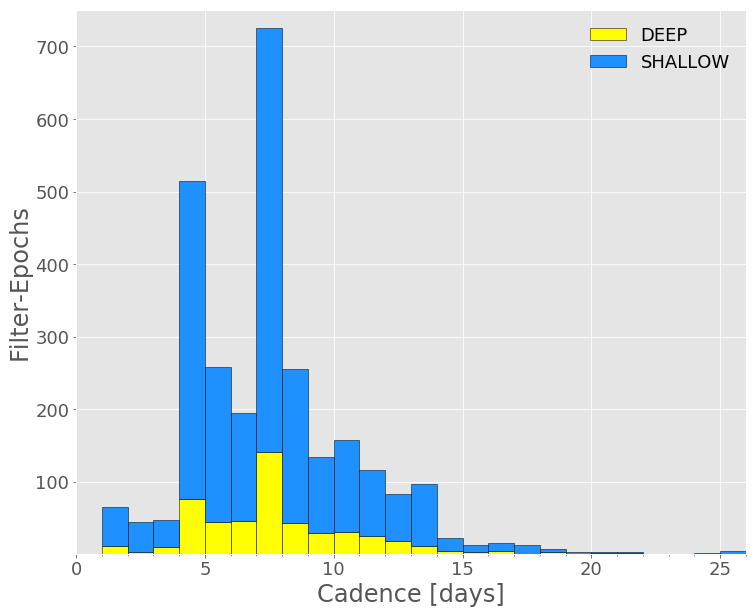

In [87]:
f, ax1 = plt.subplots(1, figsize=(12,10))
mpl.style.use('ggplot')

ax1.hist([deep['tdiff'],shallow['tdiff']],bins=np.arange(0,30,1), edgecolor='black', 
        color = ['yellow', 'dodgerblue'], label = ['DEEP','SHALLOW'], stacked=True)

ax1.set_xlabel('Cadence [days]', fontsize=24)
ax1.set_ylabel('Filter-Epochs', fontsize=24)
ax1.tick_params(axis='both', which='major', labelsize=18)

ax1.legend(loc='upper right',frameon=False,fontsize=18)

ax1.set_ylim(1,750)
ax1.set_xlim(0,26)
        
ax1.xaxis.set_major_locator(MultipleLocator(5))
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))    

#ax1.set_yscale('log')
#ax1.set_ylim(1,1000)
plt.show()




len(cadence[(cadence['tdiff'] >= 9) & (cadence['tdiff'] <=13)])
f.savefig('DES-SN3_Cadence_DeepShallowv2.pdf', format='pdf', bbox_inches='tight')


In [124]:
why = cadence[cadence['tdiff'] > 15]
print why.sort_values(by=['NITE','FIELD','BAND']), len(why.sort_values(by='NITE'))

      FIELD BAND  MJD_OBS      NITE  season  tdiff
571   SN-C3    g    56595  20131029       1   16.0
1978  SN-X1    i    56618  20131121       1   16.0
2112  SN-X1    z    56618  20131121       3   16.0
2437  SN-X3    g    56627  20131130       3   20.0
2177  SN-X2    g    56628  20131201       3   19.0
2242  SN-X2    i    56628  20131201       2   19.0
2309  SN-X2    r    56628  20131201       1   19.0
2376  SN-X2    z    56628  20131201       1   19.0
2183  SN-X2    g    56690  20140201       3   23.0
2381  SN-X2    z    56690  20140201       1   23.0
584   SN-C3    g    56885  20140815       2  191.0
652   SN-C3    i    56885  20140815       1  188.0
719   SN-C3    r    56885  20140815       3  191.0
788   SN-C3    z    56885  20140815       3  190.0
851   SN-E1    g    56885  20140815       2  188.0
921   SN-E1    i    56885  20140815       2  188.0
989   SN-E1    r    56885  20140815       1  188.0
20    SN-C1    g    56887  20140817       1  194.0
92    SN-C1    i    56887  2014

---

### This is where we start looking at PSF

In [88]:
#Now read in the PER EXPOSURE table
filename = os.environ['HOME'] + '/Dropbox/DES/Papers/DAndrea2016/data/DESOPS/SN_TABLE_EVAL.txt' 

newqual = pd.read_csv(filename, sep=" ", header=None, skiprows=1)
newqual.columns = ['EXPNUM','NITE','FIELD','BAND','PROCESS','PATH',
                                     'FWHM','SKY','ELLIPT','T_EFF']

newqual['NITE'] = newqual['NITE'].apply(str)
newqual = newqual.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

#Strip down to Y123
newqual = newqual.query("NITE > '20130606' and NITE < '20160606'")
print 'Number of exposures in SN_TABLE_EVAL:', len(newqual)


#qual['NITE'] = qual['NITE'].apply(str)
#qual = qual.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

#Update so we're only looking at first three years
#qual = qual.query("NITE > '20130606' and NITE < '20160606'")


Number of exposures in SN_TABLE_EVAL: 6877


In [90]:
all_data = pd.merge(newqual, qual, how = 'left', on = ['NITE','BAND','FIELD'], suffixes=('_TBL','_DQ'))
#good = all_data.query("ACCEPT == 'True'")
good = all_data.query("(ACCEPT == 'True') or (ACCEPT != ACCEPT)")

print len(good)
good = good[~good['FWHM'].isnull()]
print len(good)

5974
5962


In [91]:
band = ['g', 'r', 'i', 'z']
for j, item in enumerate(band):
    print '--------------{}------------'.format(item)
    t1 = good.query("BAND == '{0}'".format(item))
    print 'MEDIAN: ',np.median(t1['EFF50']),np.median(t1['PSF']),np.median(t1['FWHM']),np.median(t1['zPSF'])
        
    

--------------g------------
MEDIAN:  nan nan 1.427 nan
--------------r------------
MEDIAN:  nan nan 1.291 nan
--------------i------------
MEDIAN:  nan nan 1.177 nan
--------------z------------
MEDIAN:  nan nan 1.099 nan


g
r
i
z


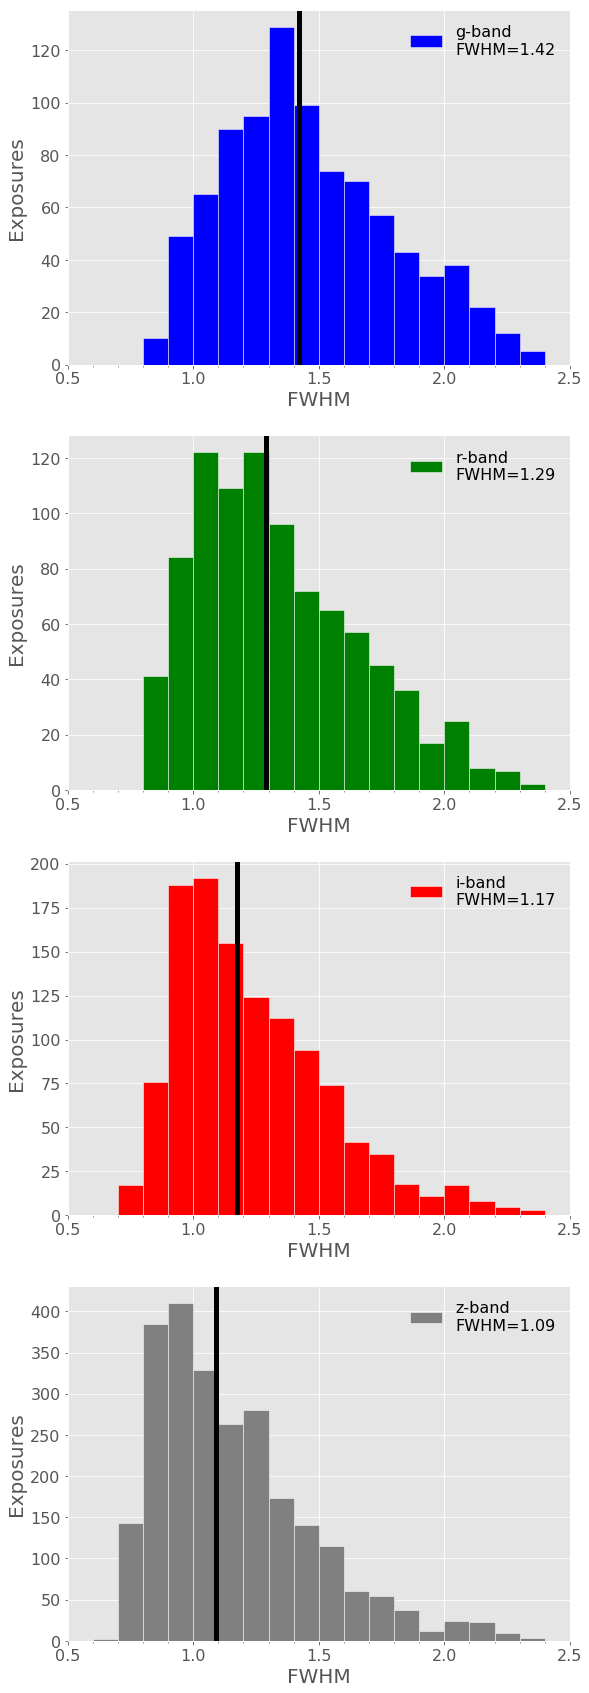

In [147]:
f, ax = plt.subplots(4,1, figsize=(9,30))

bands  = ['g','r','i','z']
color  = ['blue', 'green', 'red', 'grey']
for i in range(4):

        print bands[i]
        string = "BAND == '{0}' and FWHM > 0.1".format(bands[i])
        temp = good.query(string)
        
        FWHM = np.median(temp['FWHM'])
        sFWHM = '{0:4.2f}'.format(FWHM)

        ax[i].hist(temp['FWHM'], bins=np.arange(0.5,2.5,0.1), color=color[i], edgecolor='white',  
                     label = bands[i]+'-band\nFWHM='+sFWHM)

        ax[i].set_xlabel('FWHM', fontsize='20')
        ax[i].set_ylabel('Exposures', fontsize='20')
        ax[i].tick_params(axis='both', which='major', labelsize=14)
        ax[i].legend(loc='upper right',frameon=False,fontsize=16)

        t = ax[i].get_ylim()
        ax[i].plot(FWHM*np.ones(100),np.linspace(t[0],t[1],100),color='black')
        ax[i].set_ylim(t)
        ax[i].set_xlim(0.5,2.5)
        
        ax[i].xaxis.set_major_locator(MultipleLocator(0.5))
        ax[i].xaxis.set_minor_locator(AutoMinorLocator(5))    
        ax[i].tick_params(axis='both', which='major', labelsize=16)

plt.show()
#f.savefig('DES-SN4_Seeing.pdf', format='pdf', bbox_inches='tight')

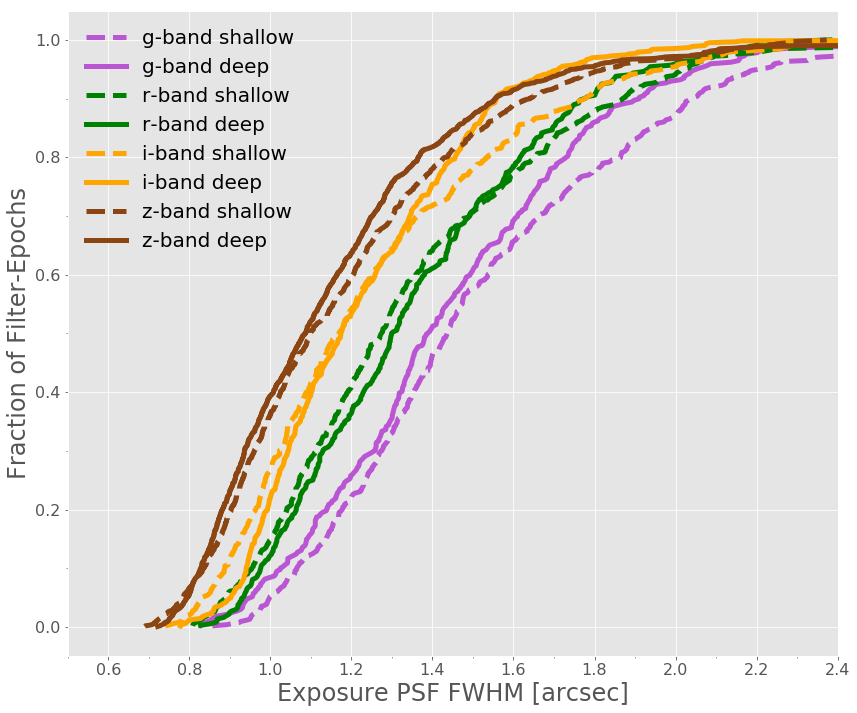

In [148]:
#PLOT FOR PAPER:  CDF of Depth by field
f, ax1 = plt.subplots(1, figsize=(12,10))

band   = ['g', 'r', 'i', 'z']
colors = ['mediumorchid','green','orange','saddlebrown']

mpl.rcParams['lines.linewidth'] = 5

deep    = good.query("FIELD == 'SN-X3' or FIELD == 'SN-C3'")
shallow = good.query("FIELD != 'SN-X3' and FIELD != 'SN-C3'")

for i,item in enumerate(band):
    flt = item
    
    t1 = shallow.query("BAND == '{0}'".format(flt))
    t2 = deep.query("BAND == '{0}'".format(flt))
    
    x1 = t1.sort_values(by='FWHM')
    y1 = 1.0+np.arange(1.0*len(x1))
    ax1.plot(x1['FWHM'],y1/len(x1),color=colors[i],linestyle='dashed',label = '{0}-band shallow'.format(flt))
        
    x2 = t2.sort_values(by='FWHM')
    y2 = 1.0+np.arange(1.0*len(x2))    
    ax1.plot(x2['FWHM'],y2/len(x2),color=colors[i],linestyle='solid',label = '{0}-band deep'.format(flt))
        
    ax1.xaxis.set_major_locator(MultipleLocator(0.2))
    ax1.xaxis.set_minor_locator(AutoMinorLocator(2))    
    ax1.yaxis.set_major_locator(MultipleLocator(0.2))
    ax1.yaxis.set_minor_locator(AutoMinorLocator(2))    

    #ax1.grid(which='minor', axis='x', linestyle='--')
    ax1.grid(which='major', axis='xy', linestyle='-',linewidth=3)
    ax1.tick_params(axis='both', which='major', labelsize=16)

    ax1.set_ylabel('Fraction of Filter-Epochs',fontsize=24)
    ax1.set_xlabel('Exposure PSF FWHM [arcsec]',fontsize=24)

    ax1.set_xlim(0.5,2.4)
    
    ax1.legend(loc='upper left',frameon=False,fontsize=20)
  
f.savefig('DES-SN3_FWHMCDF.pdf', format='pdf', bbox_inches='tight')
#plt.close()
plt.tight_layout()
plt.show()

In [149]:
print 'From SN_TABLE_EVAL.txt'
print 'Total Number of Exposures ', len(newqual)
print '----'

for i in range(3):
    date = "201{0}0606"
    test = newqual.query("NITE > {0} and NITE < {1}".format(date.format(3+i), date.format(4+i)))

    print 'Number of Exposures in Y{0}: '.format(i),len(test)
    
t = newqual.groupby(['NITE','FIELD','BAND']).size().reset_index().rename(columns={0:'count'})
print len(t)

From SN_TABLE_EVAL.txt
Total Number of Exposures  6877
----
Number of Exposures in Y0:  0
Number of Exposures in Y1:  0
Number of Exposures in Y2:  0
3423


In [150]:
#NOTE that SN_TABLE_EVAL has *every exposure* that is in the DES DB!!

In [151]:
#Now read in the PER EXPOSURE table
filename = os.environ['HOME'] + '/Dropbox/DES/Papers/DAndrea2016/data/DESOPS/SN_TABLE_EVAL.txt' 

newqual = pd.read_csv(filename, sep=" ", header=None, skiprows=1)
newqual.columns = ['EXPNUM','NITE','FIELD','BAND','PROCESS','PATH',
                                     'FWHM','SKY','ELLIPT','T_EFF']
newqual = newqual.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

#Strip down to Y123
newqual = newqual.query('NITE > 20130606 and NITE < 20160606')
print 'Number of exposures in SN_TABLE_EVAL:', len(newqual)

Number of exposures in SN_TABLE_EVAL: 6877


In [152]:
#Sole purpose of this is to get MJD for each sequence
new_data = pd.merge(qual, exp, how='left', \
                   left_on='EXPNUM', right_on='EXPNUM', suffixes=('_qual','_exp'))
print 'Length of all entries: ',len(new_data)

Length of all entries:  3179


In [157]:
new_data[new_data['FIELD_qual'] == 'SN-X3']

a NITE_qual FIELD_qual BAND_qual   ATT  EXPNUM  STATUS   PSF   AIR   FAKE  zPSF  SNR20  EFF50 ACCEPT  RADEG  DECDEG FIELD_exp  NITE_exp BAND_exp       MJD_OBS  EXPTIME
33    2282  20160120      SN-X3         g     1  513753  ACTIVE  1.35  1.25   68.7  1.07  108.6   23.5   True  36.45    -4.6     SN-X3  20160120        g  57408.041383    200.0
40    2276  20160118      SN-X3         r     1  512979  ACTIVE  1.57  1.61   89.1  1.14  156.5   23.9   True  36.45    -4.6     SN-X3  20160118        r  57406.100096    400.0
54    2270  20160115      SN-X3         i     1  511732  ACTIVE  1.00  1.36   98.1  0.83  293.9   24.7   True  36.45    -4.6     SN-X3  20160115        i  57403.072813    360.0
60    2268  20160114      SN-X3         z     2  511341  ACTIVE  0.92  1.36   96.5  0.79  301.7   24.7   True  36.45    -4.6     SN-X3  20160114        z  57402.062018    330.0
74    2265  20160113      SN-X3         r     1  511098  ACTIVE  1.25  1.20   95.3  1.08  328.9   25.1   True  36.45    -4.6     SN-X3  20160113        r  57401.044308    400.0
79    2261  20160112      SN-X3         g     2  510812  ACTIVE  1.70  1.58   94.9  1.17  205.7   24.5   True  36.45    -4.6     SN-X3  20160112        g  57400.115143    200.0
94    2181  20160108      SN-X3         i     2  509360  ACTIVE  1.28  1.26   96.9  1.11  290.3   24.8   True  36.45    -4.6     SN-X3  20160108        i  57396.072655    360.0
100   2179  20160107      SN-X3         z     2  509039  ACTIVE  1.56  1.21   93.4  1.45  205.3   24.2   True  36.45    -4.6     SN-X3  20160107        z  57395.046835    330.0
119   2177  20160106      SN-X3         g     1  508811  ACTIVE  1.62  1.22   96.5  1.31  235.6   24.7   True  36.45    -4.6     SN-X3  20160106        g  57394.071236    200.0
120   2177  20160106      SN-X3         r     1  508815  ACTIVE  1.46  1.25   95.7  1.22  324.3   25.1   True  36.45    -4.6     SN-X3  20160106        r  57394.080406    400.0
140   2162  20160101      SN-X3         i     2  507741  ACTIVE  1.84  1.24   93.6  1.62  232.3   24.3   True  36.45    -4.6     SN-X3  20160101        i  57389.085206    360.0
151   2158  20151230      SN-X3         r     1  507086  ACTIVE  1.06  1.23   98.0  0.90  364.5   25.4   True  36.45    -4.6     SN-X3  20151230        r  57387.091023    400.0
152   2158  20151230      SN-X3         z     1  507074  ACTIVE  1.18  1.15   95.9  1.12  278.9   24.5   True  36.45    -4.6     SN-X3  20151230        z  57387.044127    330.0
157   2156  20151229      SN-X3         g     6  506791  ACTIVE  1.45  1.13   97.8  1.22  250.0   25.1   True  36.45    -4.6     SN-X3  20151229        g  57386.056474    200.0
180   2154  20151228      SN-X3         i     1  506628  ACTIVE  1.43  1.12   95.5  1.34  317.8   24.8   True  36.45    -4.6     SN-X3  20151228        i  57385.040367    360.0
205   2140  20151219      SN-X3         r     1  504043  ACTIVE  1.37  1.16   91.4  1.20  179.1   23.9   True  36.45    -4.6     SN-X3  20151219        r  57376.096694    400.0
218   2131  20151216      SN-X3         g     1  502640  ACTIVE  1.37  1.11   98.8  1.16  229.8   24.7   True  36.45    -4.6     SN-X3  20151216        g  57373.064090    200.0
219   2131  20151216      SN-X3         z     1  502644  ACTIVE  1.11  1.13   95.3  1.06  269.1   24.6   True  36.45    -4.6     SN-X3  20151216        z  57373.073287    330.0
248   2129  20151215      SN-X3         i     1  502323  ACTIVE  1.38  1.12   95.9  1.29  307.6   24.7   True  36.45    -4.6     SN-X3  20151215        i  57372.075742    360.0
249   2129  20151215      SN-X3         r     1  502319  ACTIVE  1.58  1.11   94.5  1.43  254.8   24.7   True  36.45    -4.6     SN-X3  20151215        r  57372.059654    400.0
258   2116  20151209      SN-X3         g     1  500772  ACTIVE  1.34  1.11   97.4  1.14  251.6   25.1   True  36.45    -4.6     SN-X3  20151209        g  57366.067220    200.0
259   2116  20151209      SN-X3         z     1  500776  ACTIVE  1.09  1.12   96.1  1.06  264.1   24.6   True  36.4

In [ ]:
t2.query("FIELD_qual == 'SN-X3' or FIELD_qual == 'SN-C3'")


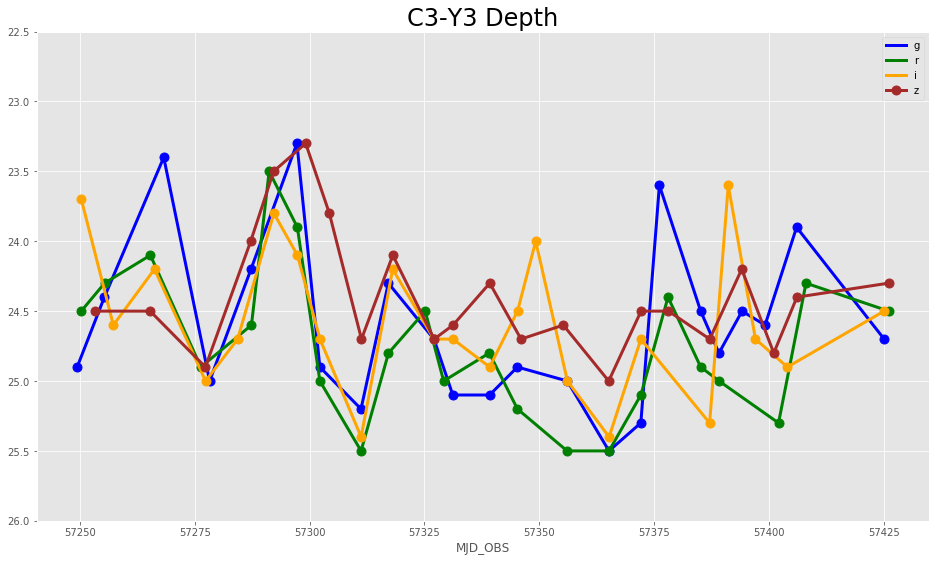

In [95]:
#See what the depth is in our DES-SN fields as a function of time
#matplotlib.style.use('ggplot')

f, ax1 = plt.subplots(1, figsize=(16,9))
mpl.style.use('ggplot')

#Just select C3, Y4
t = new_data.query("FIELD_qual == 'SN-C3' and \
                    NITE_qual > 20150606 and NITE_qual < 20160606 and \
                    EFF50 < 28 and ACCEPT == 'True'" )
t = t.sort_values(by='MJD_OBS')

mpl.rcParams['lines.linewidth'] = 3

ax1 = t.query("BAND_qual == 'g'").plot(x='MJD_OBS',y='EFF50',color='blue', ax=ax1, \
                                       label='g', marker='o', markersize='9')
t.query("BAND_qual == 'r'").plot(x='MJD_OBS',y='EFF50',color='green', ax=ax1, label='r', \
                                marker='o', markersize='9')
t.query("BAND_qual == 'i'").plot(x='MJD_OBS',y='EFF50',color='orange', ax=ax1, label='i', \
                                marker='o', markersize='9')
t.query("BAND_qual == 'z'").plot(x='MJD_OBS',y='EFF50',color='brown', ax=ax1, label='z', \
                                marker='o', markersize='9')

ax1.set_title('C3-Y3 Depth',fontsize=24)
ax1.set_ylim(26,22.5)
#t.plot(x='MJD_OBS',y='EFF50',color='green')
#t.plot(x='MJD_OBS',y='EFF50',color='orange')
#t.plot(x='MJD_OBS',y='EFF50',color='brown')
plt.show()



In [169]:
new_data.type

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3179 entries, 0 to 3178
Data columns (total 21 columns):
a             3179 non-null object
NITE_qual     3179 non-null object
FIELD_qual    3179 non-null object
BAND_qual     3179 non-null object
ATT           3179 non-null object
EXPNUM        3179 non-null int64
STATUS        3179 non-null object
PSF           2971 non-null float64
AIR           3179 non-null float64
FAKE          2971 non-null float64
zPSF          2971 non-null float64
SNR20         2971 non-null float64
EFF50         3179 non-null float64
ACCEPT        3179 non-null object
RADEG         3176 non-null float64
DECDEG        3176 non-null float64
FIELD_exp     3176 non-null object
NITE_exp      3176 non-null object
BAND_exp      3176 non-null object
MJD_OBS       3176 non-null float64
EXPTIME       3176 non-null float64
dtypes: float64(10), int64(1), object(10)
memory usage: 706.4+ KB


In [170]:
new_data.query("NITE_qual < '20160606'")


a NITE_qual FIELD_qual BAND_qual   ATT  EXPNUM  STATUS   PSF   AIR   FAKE  zPSF  SNR20  EFF50 ACCEPT    RADEG   DECDEG FIELD_exp  NITE_exp BAND_exp       MJD_OBS     EXPTIME
0     2310  20160208      SN-X1         g     1  515323  ACTIVE  2.40  1.70  100.0  1.58   99.9   23.1   True  34.4757  -4.9295     SN-X1  20160208        g  57427.049886  175.000000
1     2310  20160208      SN-X1         i     1  515325  ACTIVE  2.02  1.76   85.2  1.44   68.7   22.9   True  34.4757  -4.9295     SN-X1  20160208        i  57427.054310  200.000000
2     2310  20160208      SN-X1         r     1  515324  ACTIVE  2.02  1.73   98.5  1.40   93.0   23.1   True  34.4757  -4.9295     SN-X1  20160208        r  57427.052237  150.000000
3     2310  20160208      SN-X1         z     1  515326  ACTIVE  1.89  1.82   66.0  1.37   54.7   22.5   True  34.4757  -4.9295     SN-X1  20160208        z  57427.056950  200.000000
4     2310  20160208      SN-X2         g     3  515329    JUNK  2.12  1.80  100.0  1.35  109.6   23.3  False  35.6645  -6.4121     SN-X2  20160208        g  57427.063392  175.000000
5     2310  20160208      SN-X2         i     1  515331  ACTIVE  1.85  1.87   88.2  1.27   71.0   23.0   True  35.6645  -6.4121     SN-X2  20160208        i  57427.067826  200.000000
6     2310  20160208      SN-X2         r     1  515330  ACTIVE  2.03  1.84   96.8  1.35   89.8   23.2   True  35.6645  -6.4121     SN-X2  20160208        r  57427.065747  150.000000
7     2310  20160208      SN-X2         z     3  515332    JUNK  1.68  1.93   69.1  1.17   57.8   22.7  False  35.6645  -6.4121     SN-X2  20160208        z  57427.070476  200.000000
8     2308  20160207      SN-C2         g     1  515104  ACTIVE  2.02  1.73   94.5  1.32  130.0   23.7   True  54.2743 -29.0884     SN-C2  20160207        g  57426.143065  175.000000
9     2308  20160207      SN-C2         i     1  515106  ACTIVE  1.80  1.79   92.8  1.27   80.4   22.9   True  54.2743 -29.0884     SN-C2  20160207        i  57426.147481  200.000000
10    2308  20160207      SN-C2         r     1  515105  ACTIVE  2.00  1.76   99.2  1.37  105.0   23.4   True  54.2743 -29.0884     SN-C2  20160207        r  57426.145423  150.000000
11    2308  20160207      SN-C2         z     2  515107    JUNK  1.89  1.84   66.4  1.36   55.3   22.5  False  54.2743 -29.0884     SN-C2  20160207        z  57426.150129  200.000000
12    2308  20160207      SN-C3         r     1  515095  ACTIVE  1.92  1.55   94.7  1.41  269.0   24.5   True  52.6484 -28.1000     SN-C3  20160207        r  57426.118217  400.000000
13    2308  20160207      SN-C3         z     2  515083  ACTIVE  1.61  1.32   96.4  1.41  207.0   24.3   True  52.6484 -28.1000     SN-C3  20160207        z  57426.071537  330.000000
14    2307  20160206      SN-C1         g     2  514837  ACTIVE  2.07  1.76   95.9  1.34  127.9   23.7   True  54.2743 -27.1116     SN-C1  20160206        g  57425.146381  175.000000
15    2307  20160206      SN-C1         i     1  514839  ACTIVE  1.79  1.82   96.1  1.25   86.8   23.2   True  54.2743 -27.1116     SN-C1  20160206        i  57425.150806  200.000000
16    2307  20160206      SN-C1         r     2  514838  ACTIVE  1.83  1.79   98.3  1.24  116.0   23.5   True  54.2743 -27.1116     SN-C1  20160206        r  57425.148738  150.000000
17    2307  20160206      SN-C1         z     1  514840  ACTIVE  1.84  1.88   71.7  1.30   62.6   22.8   True  54.2743 -27.1116     SN-C1  20160206        z  57425.153455  200.000000
18    2307  20160206      SN-C3         g     1  514816  ACTIVE  1.68  1.44   98.8  1.22  215.9   24.7   True  52.6484 -28.1000     SN-C3  20160206        g  57425.110244  200.000000
19    2307  20160206      SN-C3         i     2  514810  ACTIVE  1.61  1.32   96.5  1.36  247.0   24.5   True  52.6484 -28.1000     SN-C3  20160206        i  57425.086693  360.000000
20    2282  20160120      SN-C1         g     1  513763  ACTIVE  1.26  1.04  100.0  1.12   82.6   23.2   True  54.2743 -27.1116     SN-C1  20160120        g  57408.06

2663
540 123
541 124
548 126
534 127


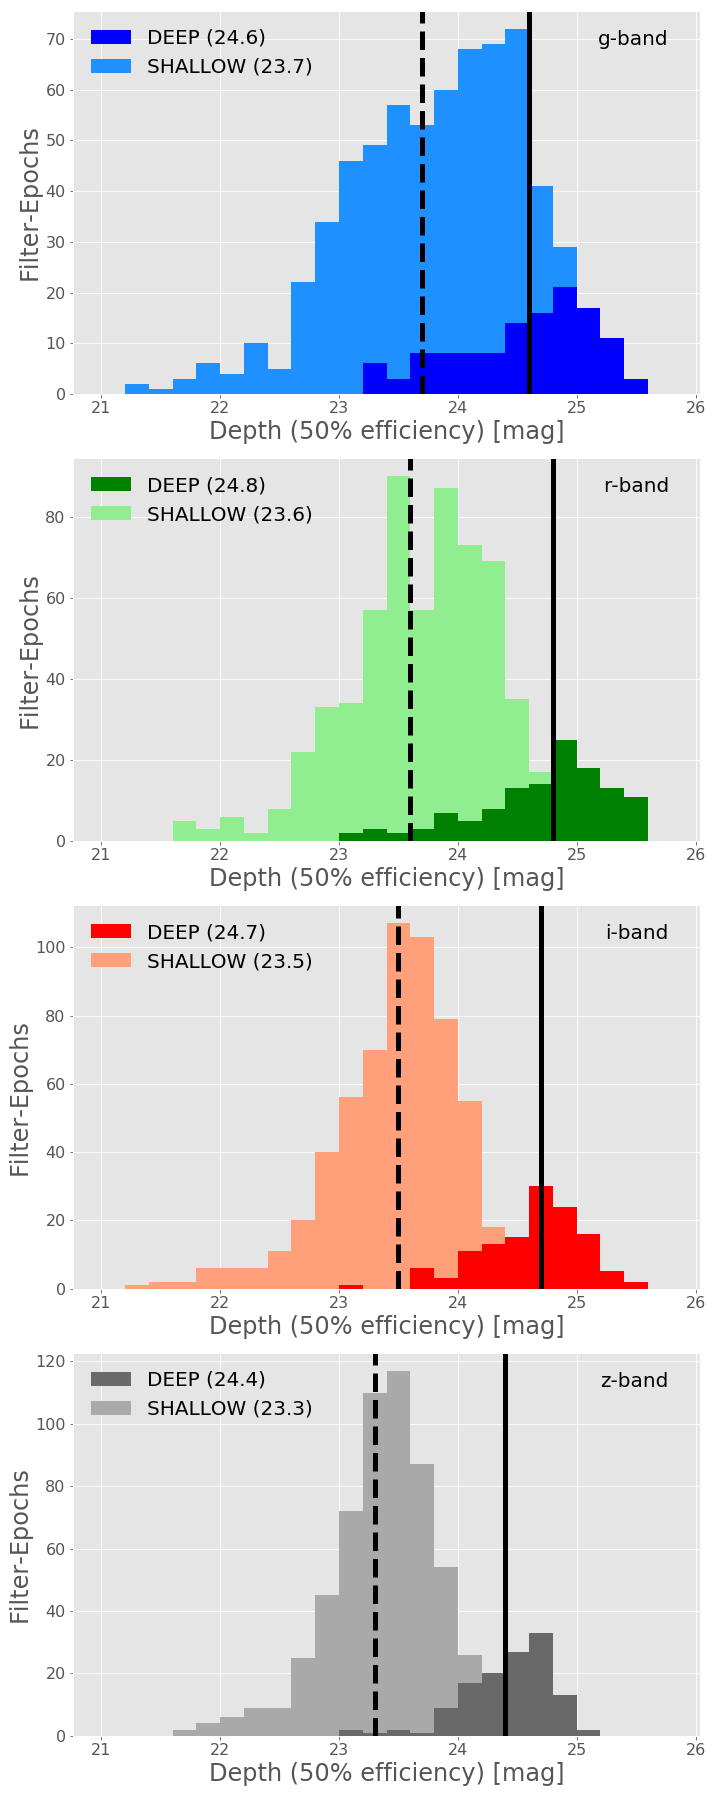

In [172]:
#PLOT FOR PAPER:  Histogram of Depth by field
f, ax1 = plt.subplots(4,1, figsize=(10,25))
ax2 = ax1.flatten()

t2 = new_data.query("ACCEPT == 'True' and NITE_qual > '20130606' and NITE_qual < '20160606'")
print len(t2)
deep    = t2.query("FIELD_qual == 'SN-X3' or FIELD_qual == 'SN-C3'")
shallow = t2.query("FIELD_qual != 'SN-X3' and FIELD_qual != 'SN-C3'")

color1  = ['blue', 'green', 'red', 'dimgrey']
color2  = ['dodgerblue', 'lightgreen', 'lightsalmon', 'darkgrey']
band = ['g', 'r', 'i', 'z']

for i,ax in enumerate(ax2):
    flt = band[i]
    
    t1 = shallow.query("BAND_qual == '{0}'".format(flt))
    t2 = deep.query("BAND_qual == '{0}'".format(flt))
    
    print len(t1),len(t2)
    
    ax.hist([t2['EFF50'], t1['EFF50']], \
            bins=np.arange(21,26,0.2), color=[color1[i],color2[i]], \
            label=['DEEP ({0})'.format(t2['EFF50'].median()),'SHALLOW ({0})'.format(t1['EFF50'].median())], \
            stacked='True', width=0.2) 

    ax.tick_params(axis='both', which='major', labelsize=16)
    
    ax.set_ylabel('Filter-Epochs',fontsize=24)
    ax.set_xlabel('Depth (50% efficiency) [mag]',fontsize=24)

    aa = ax.get_ylim()
    ax.plot(t2['EFF50'].median()*np.ones(100), np.linspace(aa[0],aa[1],100), linestyle='solid', color='black')
    ax.plot(t1['EFF50'].median()*np.ones(100), np.linspace(aa[0],aa[1],100), linestyle='dashed', color='black')
    ax.set_ylim(aa)
        
    ax.legend(loc='upper left',frameon=False,fontsize=20)
    ax.text(0.95,0.95,'{0}-band'.format(flt),fontsize=20,ha='right',va='top',transform = ax.transAxes)

f.savefig('DES-SN3_DepthHist.pdf', format='pdf', bbox_inches='tight')
#plt.close()

plt.tight_layout()
plt.show()

In [138]:
print len(color1)
print len(color2)


4
4


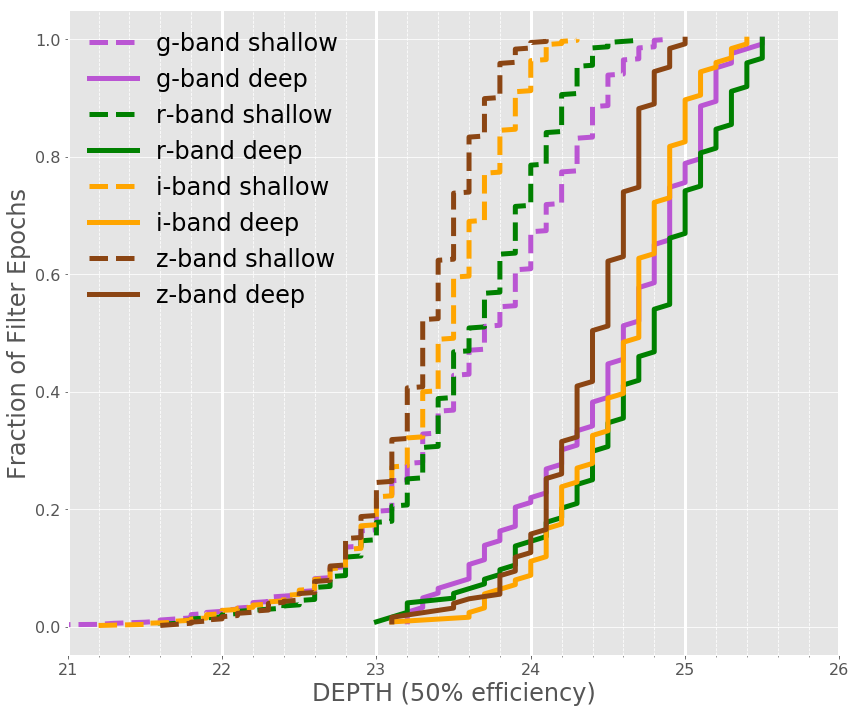

In [97]:
#PLOT FOR PAPER:  CDF of Depth by field
f, ax1 = plt.subplots(1, figsize=(12,10))

t2 = new_data.query("ACCEPT == 'True'")

deep    = t2.query("FIELD_qual == 'SN-X3' or FIELD_qual == 'SN-C3'")
shallow = t2.query("FIELD_qual != 'SN-X3' and FIELD_qual != 'SN-C3'")

band   = ['g', 'r', 'i', 'z']
colors = ['mediumorchid','green','orange','saddlebrown']

mpl.rcParams['lines.linewidth'] = 5

for i,item in enumerate(band):
    flt = item
    
    t1 = shallow.query("BAND_qual == '{0}'".format(flt))
    t2 = deep.query("BAND_qual == '{0}'".format(flt))
    
    x1 = t1.query("NITE_qual > 20130606 and NITE_qual < 20160606").sort_values(by='EFF50')
    y1 = 1.0+np.arange(1.0*len(x1))
    ax1.plot(x1['EFF50'],y1/len(x1),color=colors[i],linestyle='dashed',label = '{0}-band shallow'.format(flt))
        
    x2 = t2.query("NITE_qual > 20130606 and NITE_qual < 20160606").sort_values(by='EFF50')
    y2 = 1.0+np.arange(1.0*len(x2))    
    ax1.plot(x2['EFF50'],y2/len(x2),color=colors[i],linestyle='solid',label = '{0}-band deep'.format(flt))
        

    ax.tick_params(axis='both', which='major', labelsize=16)

    xminorLocator = MultipleLocator(0.2)
    #ax1.xaxis.set_major_locator(xmajorLocator)
    #ax1.xaxis.set_major_formatter(xmajorFormatter)
    ax1.xaxis.set_minor_locator(xminorLocator)
    ax1.grid(which='minor', axis='x', linestyle='--')
    ax1.grid(which='major', axis='x', linestyle='-',linewidth=3)

    #yminorLocator = AutoMinorLocator()
    #ax1.yaxis.set_minor_locator(yminorLocator)
    ax1.tick_params(axis='both', which='major', labelsize=16)

    
    ax1.set_ylabel('Fraction of Filter Epochs',fontsize=24)
    ax1.set_xlabel('DEPTH (50% efficiency)',fontsize=24)

    ax1.set_xlim(21,26)
    
    ax1.legend(loc='upper left',frameon=False,fontsize=24)
  
#f.savefig('DES-SN3_DepthCDF.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

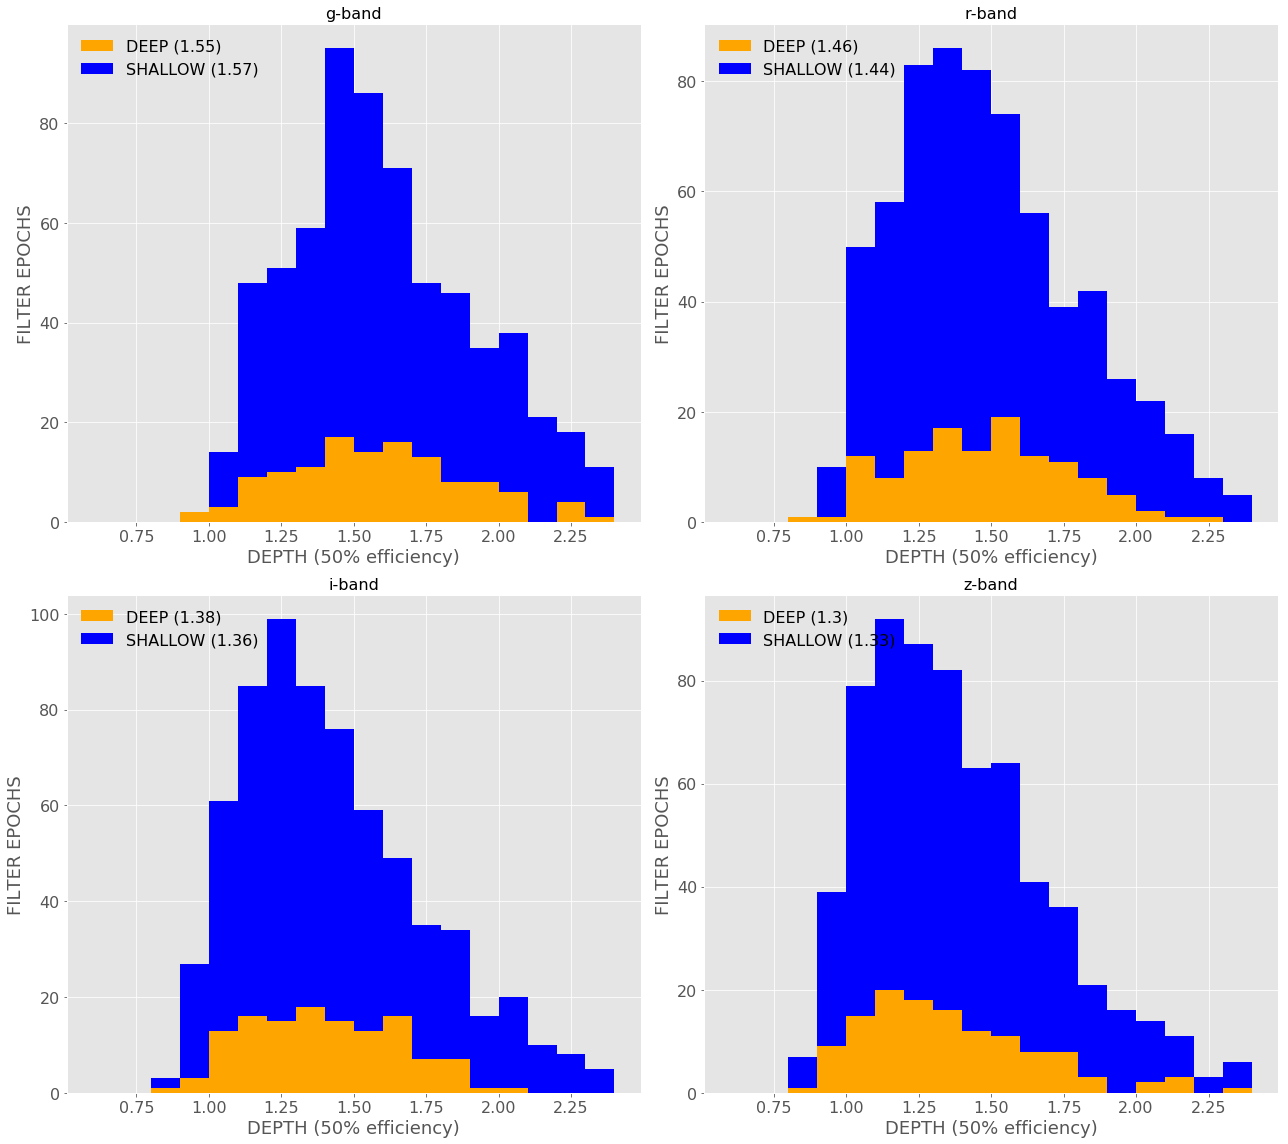

In [98]:
#PLOT FOR PAPER:  Seeing for each sequence, from COADD, from SN_STATUS page
f, ax1 = plt.subplots(2,2, figsize=(18,16))
ax2 = ax1.flatten()

band = ['g', 'r', 'i', 'z']

for i,ax in enumerate(ax2):
    flt = band[i]
    
    t1 = shallow.query("BAND_qual == '{0}'".format(flt))
    t2 = deep.query("BAND_qual == '{0}'".format(flt))
    
    ax.hist([t2['PSF'], t1['PSF']], \
            bins=np.arange(0.6,2.5,0.1), color=['orange','blue'], \
            label=['DEEP ({0})'.format(t2['PSF'].median()),'SHALLOW ({0})'.format(t1['PSF'].median())], \
            stacked='True', width=0.1) 

    ax.tick_params(axis='both', which='major', labelsize=16)
    
    ax.set_ylabel('FILTER EPOCHS',fontsize=18)
    ax.set_xlabel('DEPTH (50% efficiency)',fontsize=18)

    ax.legend(loc='upper left',frameon=False,fontsize=16)
    ax.set_title('{0}-band'.format(flt),fontsize=16)

plt.tight_layout()
plt.show()

In [ ]:
#PLOT FOR PAPER:  Seeing of each exposure from SN_TABLE_EVAL




In [68]:
band = ['g', 'r', 'i', 'z']
for j, item in enumerate(band):
    print '--------------{}------------'.format(item)
    t1 = deep.query("BAND_qual == '{0}'".format(item))
    print 'MEDIAN: ',np.median(t1['EFF50']),np.median(t1['PSF'])
        
    

--------------g------------
MEDIAN:  24.6 1.55
--------------r------------
MEDIAN:  24.8 1.46
--------------i------------
MEDIAN:  24.7 1.38
--------------z------------
MEDIAN:  24.4 1.3


---

### Here we examine cadence statistics and total number of exposures that are of good quality

In [1]:
t1 = new_data
t2 = new_data.query("ACCEPT == 'True'")
print len(t1)
print len(t2)

#Determine length of observations
bands = ['g','r','i','z']
t_exp_shallow = {'g':175, 'r':150, 'i':200, 'z':400}
t_exp_deep    = {'g':600, 'r':1200, 'i':1800, 'z':3630}

print 'deep, good'
print '----------'
deep    = t2.query("FIELD_qual == 'SN-X3' or FIELD_qual == 'SN-C3'")
for i in bands:
    nexp = len(deep.query("BAND_qual == '{0}'".format(i)))
    print i, nexp, nexp*t_exp_deep[i]

print 'shallow, good'
print '----------'
shallow = t2.query("FIELD_qual != 'SN-X3' and FIELD_qual != 'SN-C3'")
for i in bands:
    nexp = len(shallow.query("BAND_qual == '{0}'".format(i)))
    print i, nexp, nexp*t_exp_shallow[i]

print '   '
print '---'
print '   '

print 'deep, all'
print '----------'
deep    = t1.query("FIELD_qual == 'SN-X3' or FIELD_qual == 'SN-C3'")
for i in bands:
    nexp = len(deep.query("BAND_qual == '{0}'".format(i)))
    print i, nexp, nexp*t_exp_deep[i]

print 'shallow, all'
print '----------'
shallow = t1.query("FIELD_qual != 'SN-X3' and FIELD_qual != 'SN-C3'")
for i in bands:
    nexp = len(shallow.query("BAND_qual == '{0}'".format(i)))
    print i, nexp, nexp*t_exp_shallow[i]
    


NameError: name 'new_data' is not defined

In [ ]:
#Determine The length of the observing season


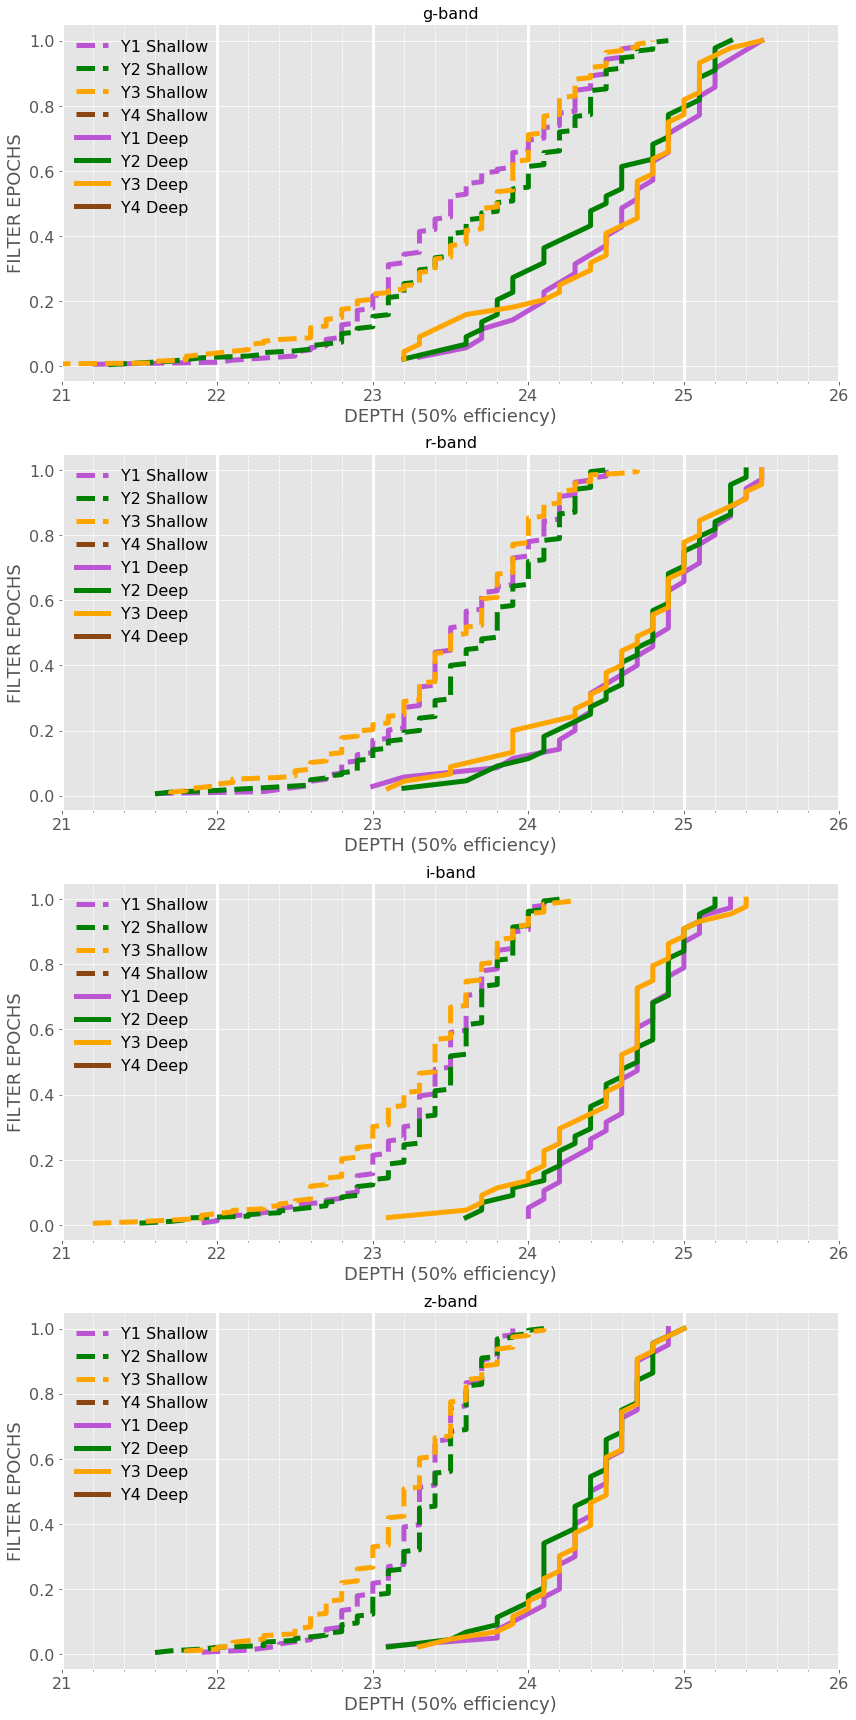

In [69]:
f, ax1 = plt.subplots(4,1, figsize=(12,24))
ax2 = ax1.flatten()

mpl.style.use('ggplot')


t2 = new_data.query("ACCEPT == 'True' and NITE_qual > 20130606 and NITE_qual < 20160606")

deep    = t2.query("FIELD_qual == 'SN-X3' or FIELD_qual == 'SN-C3'")
shallow = t2.query("FIELD_qual != 'SN-X3' and FIELD_qual != 'SN-C3'")

band   = ['g', 'r', 'i', 'z']
colors = ['mediumorchid','green','orange','saddlebrown']

mpl.rcParams['lines.linewidth'] = 5

for i,ax in enumerate(ax2):
    NITE_LOW  = '201{0}0606'
    NITE_HIGH = '201{0}0606'
    
    flt = band[i]
    
    t1 = shallow.query("BAND_qual == '{0}'".format(flt))
    t2 = deep.query("BAND_qual == '{0}'".format(flt))
    
    for j in range(4):
        x1 = t1.query("NITE_qual > 201{0}0606 and NITE_qual < 201{1}0606".format(j+3,j+4)).sort_values(by='EFF50')
        y1 = 1.0+np.arange(1.0*len(x1))
        
        ax.plot(x1['EFF50'],y1/len(x1),color=colors[j],linestyle='dashed',label = 'Y{0} Shallow'.format(j+1))
        
    for j in range(4):
        x2 = t2.query("NITE_qual > 201{0}0606 and NITE_qual < 201{1}0606".format(j+3,j+4)).sort_values(by='EFF50')
        y2 = 1.0+np.arange(1.0*len(x2))
        
        ax.plot(x2['EFF50'],y2/len(x2),color=colors[j],linestyle='solid',label = 'Y{0} Deep'.format(j+1))
        

    ax.tick_params(axis='both', which='major', labelsize=16)

    xminorLocator = MultipleLocator(0.2)
    #ax1.xaxis.set_major_locator(xmajorLocator)
    #ax1.xaxis.set_major_formatter(xmajorFormatter)
    ax.xaxis.set_minor_locator(xminorLocator)
    ax.grid(which='minor', axis='x', linestyle='--')
    ax.grid(which='major', axis='x', linestyle='-',linewidth=3)

    #yminorLocator = AutoMinorLocator()
    #ax1.yaxis.set_minor_locator(yminorLocator)
    
    
    ax.set_ylabel('FILTER EPOCHS',fontsize=18)
    ax.set_xlabel('DEPTH (50% efficiency)',fontsize=18)

    ax.set_xlim(21,26)
    
    ax.legend(loc='upper left',frameon=False,fontsize=16)
    ax.set_title('{0}-band'.format(flt),fontsize=16)

plt.tight_layout()
plt.show()

In [64]:
band = ['g', 'r', 'i', 'z']
for j, item in enumerate(band):
    print '--------------{}------------'.format(item)
    temp = []
    t1 = deep.query("BAND_qual == '{0}'".format(item))
    ll = len(t1)
    for i in np.arange(21.0,25.0,0.1):
        t2 = deep.query("BAND_qual == '{0}' and EFF50 < {1}".format(item,i))
        temp.append([i,1.0*len(t2)/ll])

    print 'MEDIAN: ',np.median(t1['EFF50'])
    for item in temp:
        print item[0],item[1]
        
    

--------------g------------
MEDIAN:  24.6
21.0 0.0
21.1 0.0
21.2 0.0
21.3 0.0
21.4 0.0
21.5 0.0
21.6 0.0
21.7 0.0
21.8 0.0
21.9 0.0
22.0 0.0
22.1 0.0
22.2 0.0
22.3 0.0
22.4 0.0
22.5 0.0
22.6 0.0
22.7 0.0
22.8 0.0
22.9 0.0
23.0 0.0
23.1 0.0
23.2 0.0
23.3 0.0243902439024
23.4 0.0487804878049
23.5 0.0650406504065
23.6 0.0731707317073
23.7 0.105691056911
23.8 0.138211382114
23.9 0.162601626016
24.0 0.20325203252
24.1 0.219512195122
24.2 0.268292682927
24.3 0.30081300813
24.4 0.333333333333
24.5 0.382113821138
24.6 0.447154471545
24.7 0.512195121951
24.8 0.577235772358
24.9 0.650406504065
--------------r------------
MEDIAN:  24.8
21.0 0.0
21.1 0.0
21.2 0.0
21.3 0.0
21.4 0.0
21.5 0.0
21.6 0.0
21.7 0.0
21.8 0.0
21.9 0.0
22.0 0.0
22.1 0.0
22.2 0.0
22.3 0.0
22.4 0.0
22.5 0.0
22.6 0.0
22.7 0.0
22.8 0.0
22.9 0.0
23.0 0.0
23.1 0.00806451612903
23.2 0.0161290322581
23.3 0.0403225806452
23.4 0.0403225806452
23.5 0.0403225806452
23.6 0.0564516129032
23.7 0.0645161290323
23.8 0.0806451612903
23.9 0.09

In [ ]:
connection =ea.connect()
cursor     =connection.cursor()

query = "select expnum, field, nite, band, mjd_obs " \
        "from EXPOSURE where FIELD like 'SN-%' and mjd_obs > 20130606 and mjd_obs < 20160606"

print query
#QQ=cursor.execute(query) #execute query
#QQ.description
#header = [item[0] for item in cursor.description]
#rows = cursor.fetchall()  ## Bring the data
#cols = np.array(zip(*rows))

exp=connection.query_to_pandas(query) #one line!

AttributeError: 'numpy.ndarray' object has no attribute 'get_figure'